# Working - Foster Care Analysis
This file is a working document for the Foster Care Analysis project. This is not the final version of the project. The final version will be published in a separate file.

In [66]:
# import the necessary packages

from google.cloud import storage
import pandas as pd
import numpy as np
# show all columns
pd.set_option('display.max_columns', None)

from dotenv import load_dotenv
import os

In [2]:
# import function files and environment variables

import utils

# Load the .env file
load_dotenv()

# Connect to the Google Cloud Storage bucket
service_account_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
client = storage.Client.from_service_account_json(service_account_path)
bucket_name = 'foster-care'
bucket = client.get_bucket(bucket_name)

In [12]:
# reload th imports
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/sophiechance/Documents/Cal/Github/foster_care_analysis/utils.py'>

## Read Data

In [4]:
# Read in Variable Values and Variable Definitions
variable_values_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variable Values.xlsx')) # Mapping
variables_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variables.xlsx')) # Variable Definitions

In [5]:
# Read in the raw data
raw_df_2001 = pd.read_sas(utils.read_cloud_data(bucket, '2001.sas7bdat'), format='sas7bdat') 
# raw_df_2002 = pd.read_csv(utils.read_cloud_data(bucket, '2002.tab'), sep='\t', lineterminator='\n')
# raw_df_2003 = pd.read_sas(utils.read_cloud_data(bucket, '2003.sas7bdat'), format='sas7bdat') 

In [6]:
df_2001 = utils.make_readable(raw_df_2001, variable_values_df)
# df_2002 = utils.make_readable(raw_df_2002.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)
# df_2003 = utils.make_readable(raw_df_2003.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)

# Filter and Clean Data

In [55]:
# all_records = pd.concat([df_2001, df_2002, df_2003], axis=0)
all_records = df_2001.reset_index(drop=True) # temporarily doing 2001 only so that the code runs faster
all_records = utils.remove_nan_values(all_records)

Records with a bad ID: 268620
RecNumbr Unknown: 0
Age Unknown: 0

Total Null Values: 0
Total Records: 544585
Total Columns: 61


In [56]:
# keep only the cases where the child has exited foster care
exited_df = all_records[all_records['Exited'] == 1]

In [57]:
# Create Binary label for if they have reunified
exited_df['reunified'] = 0
exited_df.loc[(exited_df['Exited'] == 1) & (exited_df['dischargeReason'] == 'Reunified with parent, primary caretaker'), 'reunified'] = 1

/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_2562/186036490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exited_df['reunified'] = 0


In [58]:
# Check to make sure the split is even
print(f"Reunified: {exited_df.reunified.value_counts()[0]}")
print(f"Not Reunified: {exited_df.reunified.value_counts()[1]}")
perc_reunified = exited_df.reunified.value_counts()[1] / exited_df.reunified.value_counts().sum()
print(f"\nPercentage Reunified: {round(perc_reunified*100, 2)}%")

Reunified: 83032
Not Reunified: 93965

Percentage Reunified: 53.09%


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
from sklearn.model_selection import train_test_split

In [132]:
ml_df = exited_df.drop(['DataYear', 'RecNumbr', 'dischargeReason', 'age2021'], axis=1)

In [133]:
ml_df = pd.get_dummies(ml_df, columns=['State', 'FIPSCode', 'Sex', 'removalManner', 'currentPlacementSetting', 'caseGoal', 'caretakerFamilyStructure', 'fosterFamilyStructure',  'raceEthnicity', 'diagnosedDisability', 'AgeAdopt', 'everAdopted', 'OutOfStatePlacement'])

In [134]:
X = ml_df.drop('reunified', axis=1)  # Features
y = ml_df['reunified']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Baseline Model

In [135]:
from sklearn.ensemble import RandomForestClassifier

In [136]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [137]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = rf.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8734745762711864
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     16666
           1       0.85      0.92      0.89     18734

    accuracy                           0.87     35400
   macro avg       0.88      0.87      0.87     35400
weighted avg       0.88      0.87      0.87     35400



Text(0, 0.5, '% Reunified')

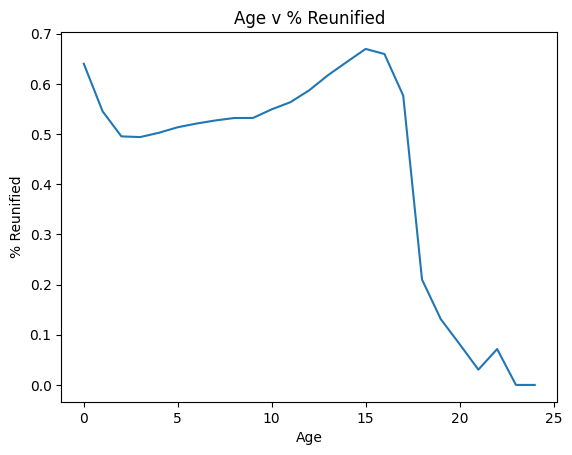

In [147]:
# plot age v % that reunified
age_reunified = exited_df[exited_df['AgeAtEnd']<25].groupby('AgeAtEnd')['reunified'].mean()
age_reunified.plot()
plt.title('Age v % Reunified')
plt.xlabel('Age')
plt.ylabel('% Reunified')

In [159]:
variables_df[variables_df['VarName'] == 'NOA']

,VarName,VarLabel,Start,Length,Columns,Type
72,NOA,Only State Or Other Support,114,1,114,INTEGER1


In [149]:
exited_df.head()

,DataYear,RecNumbr,MR,VISHEAR,PHYDIS,DSMIII,OTHERMED,TOTALREM,NUMPLEP,PHYABUSE,SEXABUSE,NEGLECT,AAPARENT,DAPARENT,AACHILD,DACHILD,CHILDIS,CHBEHPRB,PRTSDIED,PRTSJAIL,NOCOPE,ABANDMNT,RELINQSH,HOUSING,IVEFC,IVEAA,IVAAFDC,IVDCHSUP,XIXMEDCD,SSIOTHER,NOA,FCMntPay,SettingLOS,PreviousLOS,LifeLOS,AgeAtStart,AgeAtLatRem,AgeAtEnd,InAtStart,InAtEnd,Entered,Exited,Served,IsWaiting,IsTPR,AgedOut,State,FIPSCode,Sex,AgeAdopt,removalManner,currentPlacementSetting,OutOfStatePlacement,caseGoal,caretakerFamilyStructure,fosterFamilyStructure,dischargeReason,raceEthnicity,everAdopted,diagnosedDisability,age2021,reunified
3,2001,5085,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,241.0,3077.0,0.0,6727.0,18.0,1.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Alabama,Fewer than 1000 cases in the County,Female,Unknown,Court ordered,"Foster home, relative",No,Long-term foster care,Unable to determine,Not applicable,Emancipation,"NH, Black","No, has never been legally adopted",Not yet determined,40.0,0
6,2001,7376,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,205.0,5527.0,0.0,7054.0,18.0,0.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Alabama,Fewer than 1000 cases in the County,Female,Unknown,Court ordered,"Foster home, non-relative",No,Long-term foster care,Married couple,Not applicable,Emancipation,"NH, Black","No, has never been legally adopted",Not yet determined,39.0,0
7,2001,8421,0.0,0.0,0.0,0.0,0.0,1.0,13.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,6788.0,19.0,1.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Alabama,Fewer than 1000 cases in the County,Male,Unknown,Court ordered,DNG,No,Long-term foster care,Single female,Not applicable,Emancipation,"NH, Black","No, has never been legally adopted",Not yet determined,41.0,0
8,2001,8437,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,6788.0,18.0,0.0,18.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Male,Unknown,Court ordered,DNG,No,Long-term foster care,Single female,Not applicable,DNG,"NH, Black","No, has never been legally adopted",Not yet determined,39.0,0
9,2001,8573,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,241.0,32.0,0.0,6756.0,17.0,0.0,18.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Female,Unknown,Court ordered,"Foster home, non-relative",No,Long-term foster care,Single female,Married couple,DNG,"NH, Black","No, has never been legally adopted",Not yet determined,39.0,0


Text(0, 0.5, '% Reunified')

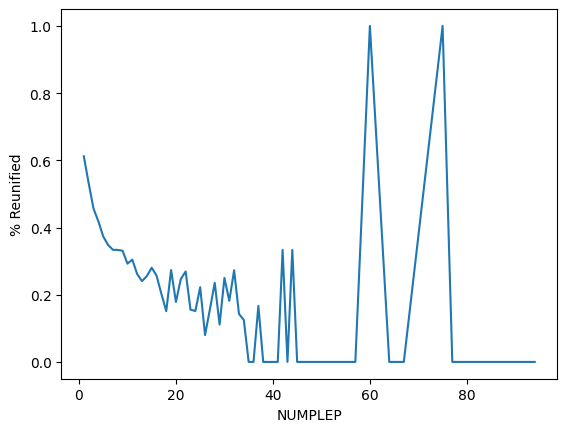

In [161]:
# plot age v % that reunified
age_reunified = exited_df.groupby('NUMPLEP')['reunified'].mean()
age_reunified.plot()
plt.ylabel('% Reunified')

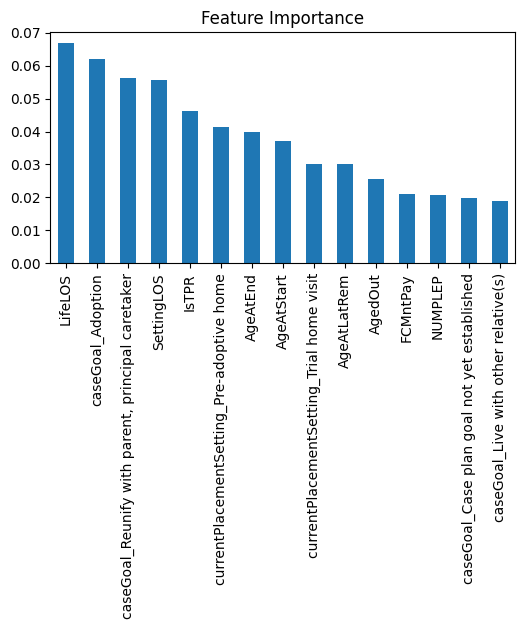

In [138]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances[:15].plot(kind='bar', figsize=(6, 3))
plt.title('Feature Importance')
plt.show()


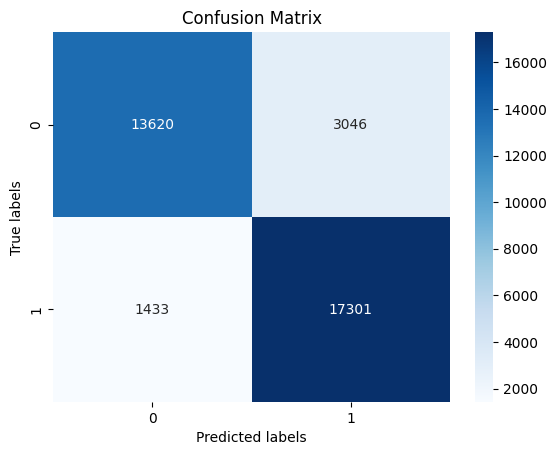

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

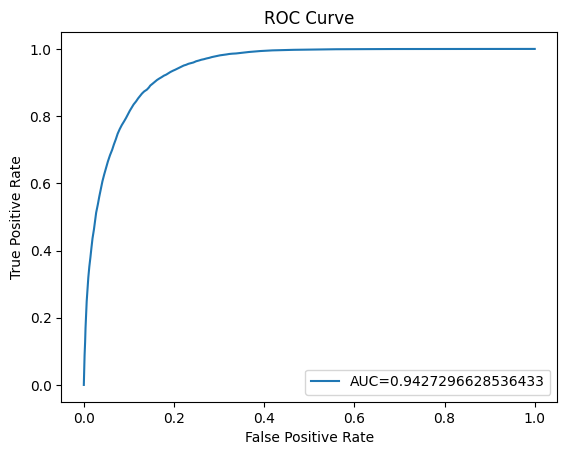

In [140]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

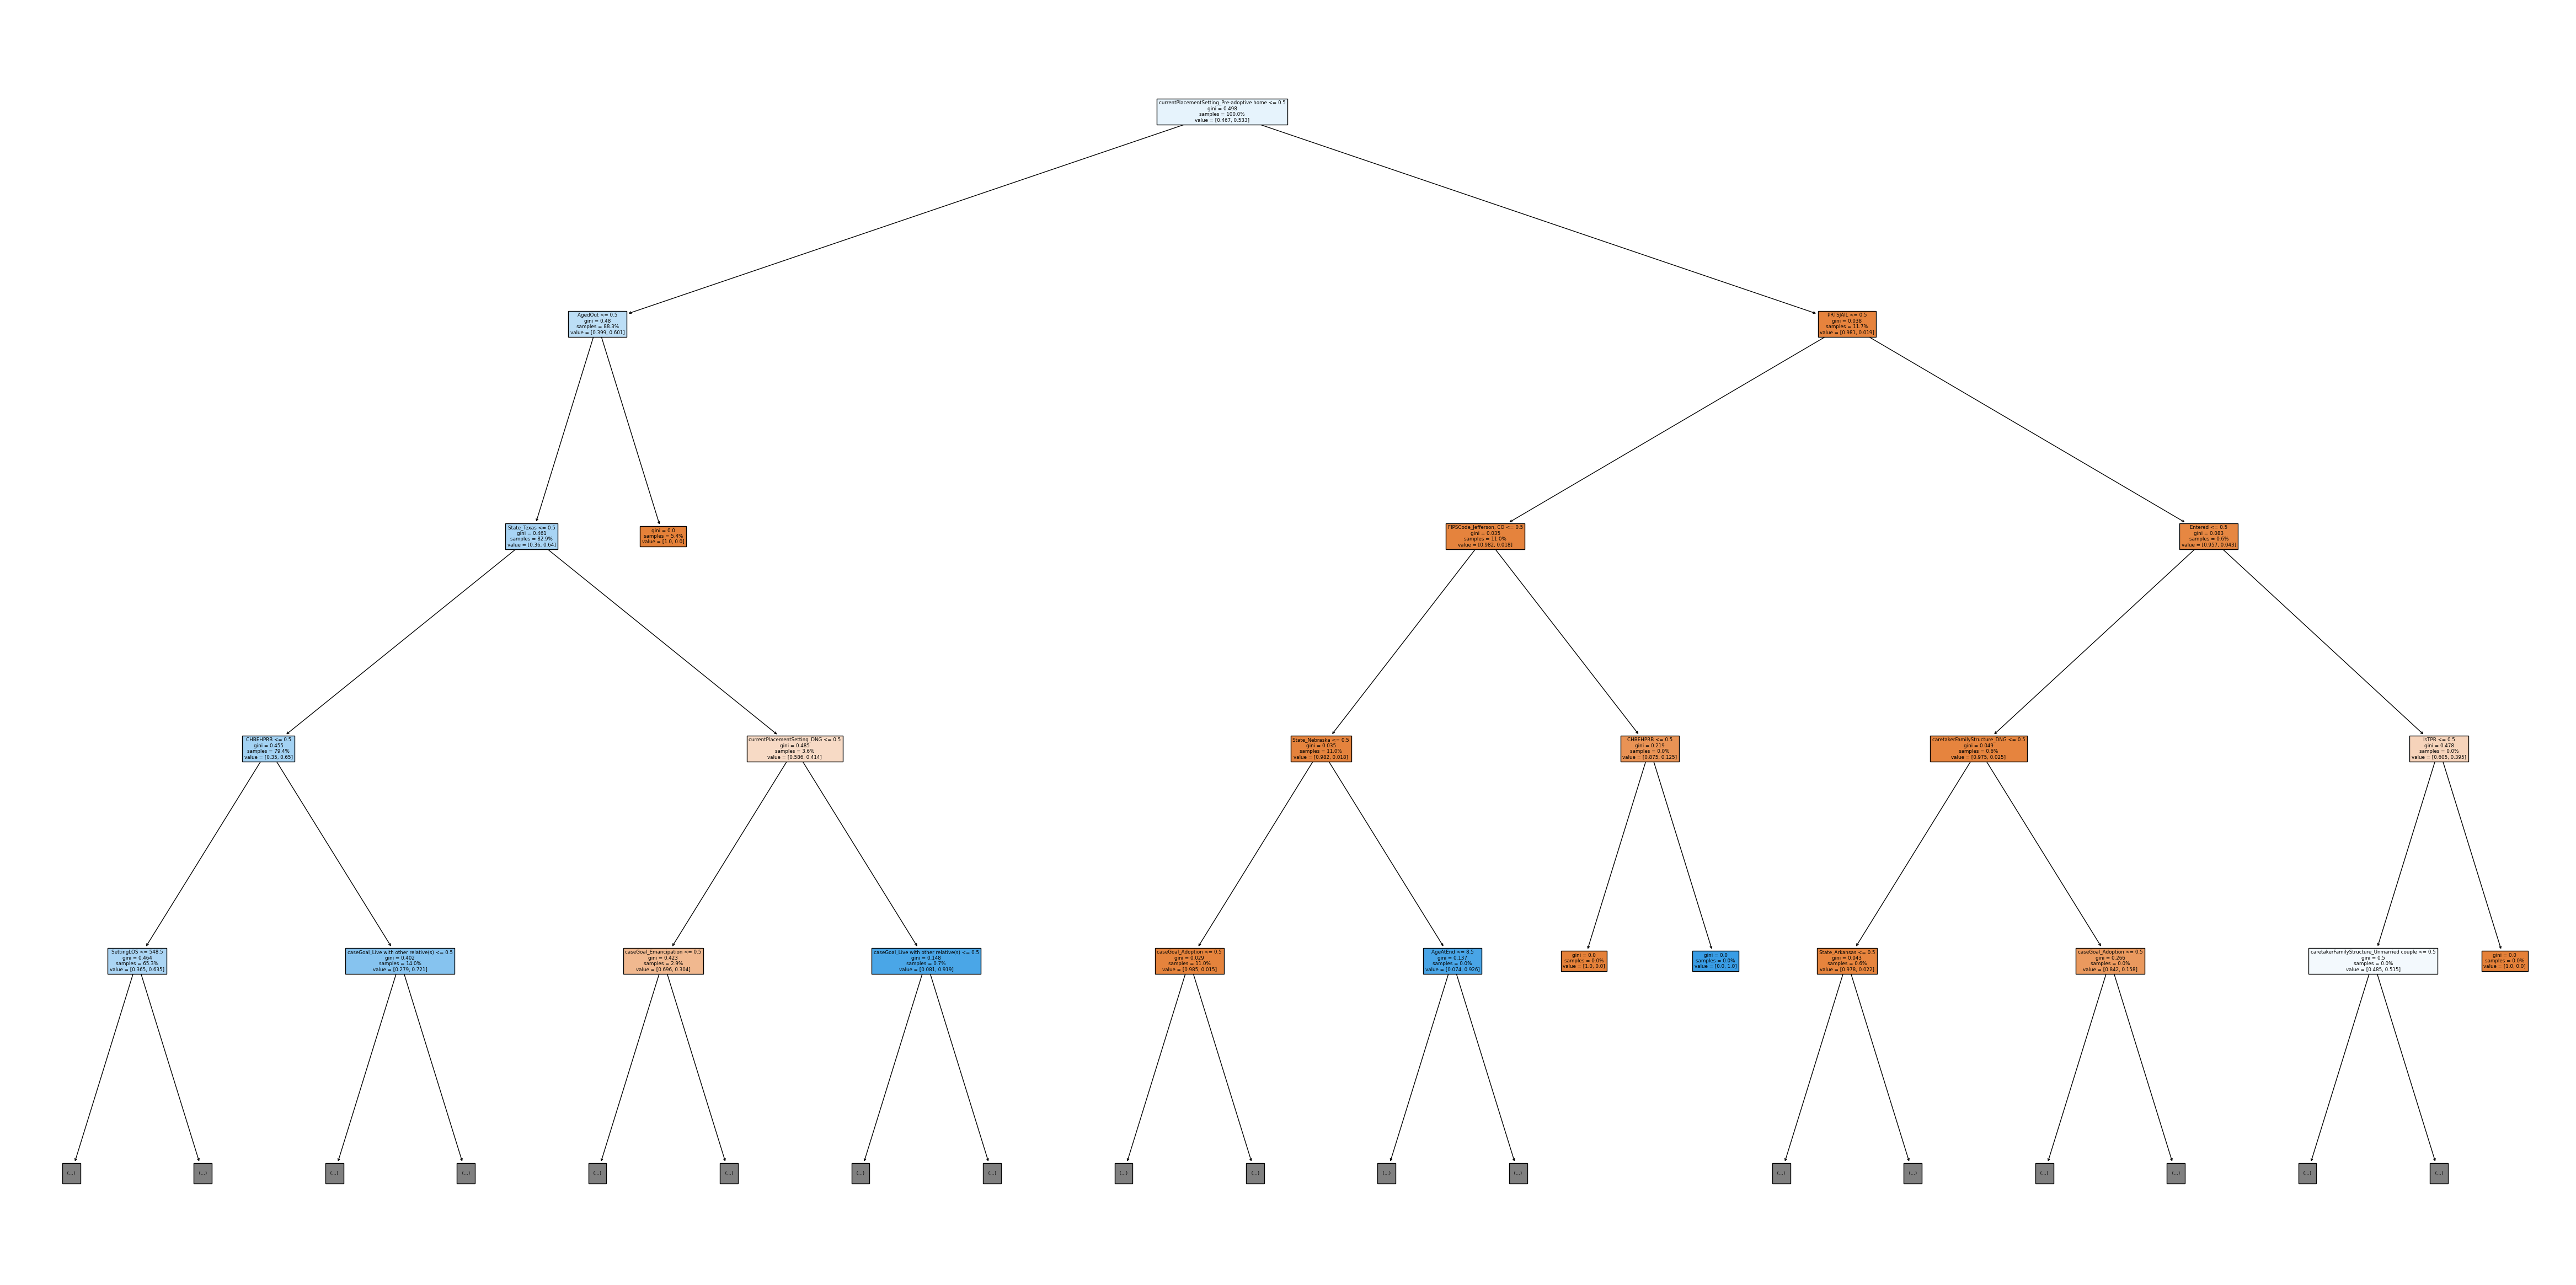

In [148]:
from sklearn.tree import plot_tree

# Pick a single tree from the forest
single_tree = rf.estimators_[0]

plt.figure(figsize=(60,30))
plot_tree(single_tree, filled=True, feature_names=X.columns, max_depth=4, proportion=True)
plt.show()

# XG Boost Model

In [100]:
import xgboost as xgb

# Convert the datasets to DMatrix data structure (optional step for improved performance)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model training parameters
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'  # You can change this to 'auc' or other relevant metrics
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

In [101]:
# Making predictions
y_pred_proba = bst.predict(dtest)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_proba]  # Convert probabilities to binary output

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8592372881355932
              precision    recall  f1-score   support

           0       0.90      0.79      0.84     16666
           1       0.83      0.92      0.87     18734

    accuracy                           0.86     35400
   macro avg       0.87      0.86      0.86     35400
weighted avg       0.86      0.86      0.86     35400



In [94]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier()
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

/Users/sophiechance/Documents/Cal/Github/foster_care_analysis/foster_venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
0.8590435976784268


# KNN Model

In [99]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6942937853107345
              precision    recall  f1-score   support

           0       0.69      0.63      0.66     16666
           1       0.70      0.75      0.72     18734

    accuracy                           0.69     35400
   macro avg       0.69      0.69      0.69     35400
weighted avg       0.69      0.69      0.69     35400

